In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import itertools
import random
%matplotlib inline

In [2]:
class Paper_detector:
    def __init__(self, image):
        self.image = image
        self.detect_paper = None
    
    def show(self, image):
        ax = plt.axes([0,0,1.5,1.5], frameon=False)
        ax.set_axis_off()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        
    def show_gray(self, image):
        ax = plt.axes([0,0,1.5,1.5], frameon=False)
        ax.set_axis_off()
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
    def sort_corners(self, corners):
        diff = np.diff(corners, axis=1)
        summ = corners.sum(axis=1)
        return np.array([corners[np.argmin(summ)], corners[np.argmax(diff)], corners[np.argmax(summ)], corners[np.argmin(diff)]])

    def find_contour(self, edges):
        _, contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        height, width = edges.shape

        min_paper_area =  width * height / 2
        paper_contour = np.array([[0,0], [0, height], [width, height], [width, 0]])

        for cont in contours:
            eps = cv2.arcLength(cont, True)
            apr_contour = cv2.approxPolyDP(cont, 0.05 * eps, True)
            if (len(apr_contour) == 4 and cv2.isContourConvex(apr_contour) and  min_paper_area < cv2.contourArea(apr_contour)):
                min_paper_area = cv2.contourArea(apr_contour)
                paper_contour = apr_contour
                
        return paper_contour
        
    def detection(self):
        img = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 5)
        img = cv2.medianBlur(img, 11)
        edges = cv2.Canny(img, 200, 250)
        
        paper_contour = self.find_contour(edges)
        curr_pts = self.sort_corners(paper_contour[:,0])
        
        height = max(np.linalg.norm(curr_pts[0] - curr_pts[1]), np.linalg.norm(curr_pts[2] - curr_pts[3]))
        width = max(np.linalg.norm(curr_pts[1] - curr_pts[2]), np.linalg.norm(curr_pts[3] - curr_pts[0]))
        
        target_pts = np.array([[0, 0], [0, height], [width, height], [width, 0]], np.float32)
        curr_pts = np.array(curr_pts, dtype='float32')
        tr_matrix = cv2.getPerspectiveTransform(curr_pts, target_pts)
        self.detect_paper = cv2.warpPerspective(self.image, tr_matrix , (int(width), int(height)))

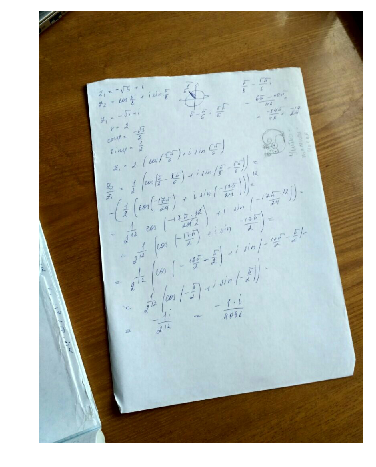

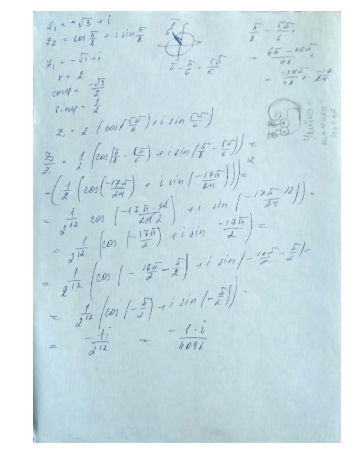

In [3]:
image = cv2.imread("1234.jpg")
detector = Paper_detector(image)
detector.detection()
detector.show(detector.image)
detector.show(detector.detect_paper)